In [1]:
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from lpu3dnet.frame import vqgan
from lpu3dnet.frame import transformer

# initialize configuration parameters for a specific experiment
experiment = 'ex11'
initialize(config_path=f"../config/{experiment}")
cfg_vqgan = compose(config_name="vqgan")
cfg_transformer = compose(config_name="transformer")
cfg_dataset = compose(config_name="dataset")

/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/journel/s0/zur74/venv/pnm-old/lib/python3.9/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [2]:
# load transformer and autoencoder
epoch_vqgan = 25
epoch_transformer = 280
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

root_path = os.path.join(cfg_dataset.checkpoints.PATH, cfg_dataset.experiment)

vqgan_path = os.path.join(root_path,f'vqgan_epoch_{epoch_vqgan}.pth')
transformer_path = os.path.join(root_path,'transformer',f'transformer_epoch_{epoch_transformer}.pth')

model_vqgan = vqgan.VQGAN(cfg_vqgan)
model_transformer = transformer.Transformer(cfg_transformer)

model_vqgan.load_checkpoint(vqgan_path)
model_transformer.load_checkpoint(transformer_path)

model_vqgan = model_vqgan.to(device)
model_transformer = model_transformer.to(device)

model_transformer.eval()
model_vqgan.eval()

number of parameters: 183.94M


VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (channel_up): Conv3d(16, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 64, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNo

In [21]:
# some defulat parameters
large_img_size = 2
sub_img_size = 2
phi_large = 0.4
phi_small = 0.05
patch_num = 8
total_features = 64


from cpgan.ooppnm import img_process
img_prc = img_process.Image_process()

def generate_sliding_windows(volume_dimension, window_size=2):
    """
    Generates coordinates for sliding windows in a 3D cubic volume.
    Args:
    - volume_dimension: The size of the cubic volume
    - window_size: The size of the sliding window (default is 2 for a 2x2x2 window)
    Returns:
    - A list of lists, where each inner list contains tuples of (i, j, k) coordinates
      for all points within a window.
    """

    windows = []

    # Traverse the 3D volume
    for i in range(volume_dimension - window_size + 1):
        for j in range(volume_dimension - window_size + 1):
            for k in range(volume_dimension - window_size + 1):
                # Initialize the current window's list of coordinates
                current_window = []
                
                # Populate the current window with coordinates
                for di in range(window_size):
                    for dj in range(window_size):
                        for dk in range(window_size):
                            current_window.append((i+di, j+dj, k+dk))
                
                # Add the current window's coordinates to the main list
                windows.append(current_window)

    return windows


def expand_cond_single(cond_base):
     features_num = 64
     cond_flatten = cond_base.unsqueeze(0).expand(features_num, -1)
     return cond_flatten.unsqueeze(0).float()


def init_ds_spatial_info(volume_dimension):
    ds = {}
    for i in range(volume_dimension):
        for j in range(volume_dimension):
            for k in range(volume_dimension):
                # store spatial info
                ds[(i, j, k)] = {}
                phi_gen = torch.rand(1) * (phi_large - phi_small) + phi_small
                ds[(i, j, k)]['phi'] = phi_gen.item()
                ds[(i, j, k)]['token'] = None
                ds[(i, j, k)]['z'] = None
                ds[(i, j, k)]['cond'] = None
                ds[(i, j, k)]['img'] = None
                ds[(i, j, k)]['phi_gen'] = None
    return ds



def add_noise_to_cond(cond,device):
    b,seq_len,_ = cond.shape
    noise = torch.randn(b, seq_len, 1).to(device)
    cond = torch.cat([cond, noise], dim=-1)
    return cond

def gen_img_from_z(z):
    with torch.no_grad():
        img = model_vqgan.decode(z)
        img = img_prc.clean_img(img)[0]
    return img



windows_idx = generate_sliding_windows(large_img_size)
ds_spatial = init_ds_spatial_info(large_img_size)





In [20]:
#%% initialize (0,0,0)
sos_token = 3000
top_k = 2
temperature = 1

phi = ds_spatial[(0,0,0)]['phi']
cond_vec = torch.tensor([phi, 0, 0, 0]).to(device)
cond_vec = expand_cond_single(cond_vec)
# cond_vec = add_noise_to_cond(cond_vec,device)

sos_tokens = torch.ones(1, total_features) * sos_token
sos_tokens = sos_tokens.long().to(device)

token_nxt = model_transformer.model.sample(
    sos_tokens,
    cond_vec,
    temperature=temperature,
    top_k=top_k,
    features_num=total_features
    )

z_current = model_vqgan.tokens_to_z(token_nxt,total_features_vec_num=total_features)

ds_spatial[(0,0,0)]['cond'] = cond_vec
ds_spatial[(0,0,0)]['z'] = z_current
ds_spatial[(0,0,0)]['token'] = token_nxt
ds_spatial[(0,0,0)]['img'] = gen_img_from_z(z_current)
ds_spatial[(0,0,0)]['phi_gen'] = img_prc.phi(ds_spatial[(0,0,0)]['img'])
# filling in z in attention window


for slide_window_idx in windows_idx:
    flat_idx = 0
    # initialize aggregated vector in each window
    cond_window = []
    token_list = [sos_tokens]
    # create normalized ijk condition vector
    for i in range(sub_img_size):
        for j in range(sub_img_size):
            for k in range(sub_img_size):
                # get absolute
                abs_ijk = slide_window_idx[flat_idx]
                

                if ds_spatial[abs_ijk]['token'] is not None:
                    cond_vec = ds_spatial[abs_ijk]['cond'].clone()
                    token_current = ds_spatial[abs_ijk]['token'].clone()
                    cond_window.append(cond_vec)
                    token_list.append(token_current)
                    flat_idx += 1
                    continue # no need for inference
                

                
                phi = ds_spatial[abs_ijk]['phi']
                # generate conditional informatino
                cond_vec = torch.tensor([phi, i, j, k]).to(device)
                cond_vec = expand_cond_single(cond_vec)
                
                # add current conditioanl vector
                cond_window.append(cond_vec)
                cond_input = torch.cat(cond_window, dim=1)

                # aggregate previous tokens
                token_input = torch.cat(token_list, dim=1)
                print(token_input.shape, cond_input.shape)
                token_nxt = model_transformer.model.sample(token_input, cond_input,temperature=temperature,top_k=top_k,features_num=total_features)
                token_list.append(token_nxt)

                # update spatial ds
                ds_spatial[abs_ijk]['token'] = token_nxt
                ds_spatial[abs_ijk]['cond'] = cond_vec
                z_current = model_vqgan.tokens_to_z(token_nxt,total_features_vec_num=total_features)
                ds_spatial[abs_ijk]['z'] = z_current
                ds_spatial[abs_ijk]['img'] = gen_img_from_z(z_current)
                ds_spatial[abs_ijk]['phi_gen'] = img_prc.phi(ds_spatial[abs_ijk]['img'])
                
                flat_idx += 1

torch.Size([1, 128]) torch.Size([1, 128, 4])
torch.Size([1, 192]) torch.Size([1, 192, 4])
torch.Size([1, 256]) torch.Size([1, 256, 4])
torch.Size([1, 320]) torch.Size([1, 320, 4])
torch.Size([1, 384]) torch.Size([1, 384, 4])
torch.Size([1, 448]) torch.Size([1, 448, 4])
torch.Size([1, 512]) torch.Size([1, 512, 4])


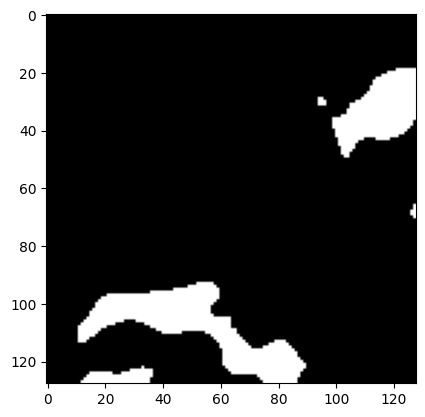

In [5]:
import numpy as np

def get_volume_shape(ds_spatial):
    max_i, max_j, max_k = 0, 0, 0
    for ijk in ds_spatial.keys():
        i, j, k = ijk
        max_i = max(max_i, i)
        max_j = max(max_j, j)
        max_k = max(max_k, k)
    return max_i + 1, max_j + 1, max_k + 1

def assemble_volume(ds_spatial):
    volume_shape = get_volume_shape(ds_spatial)
    volume = np.zeros((volume_shape[0] * 64, volume_shape[1] * 64, volume_shape[2] * 64))

    for ijk, data in ds_spatial.items():
        i, j, k = ijk
        image = data['img']
        volume[i*64:(i+1)*64, j*64:(j+1)*64, k*64:(k+1)*64] = image

    return volume

volume = assemble_volume(ds_spatial)
plt.imshow(volume[10], cmap='gray')

In [6]:
ds_spatial.keys()

dict_keys([(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])

0.03514862060546875 0.18829196691513062


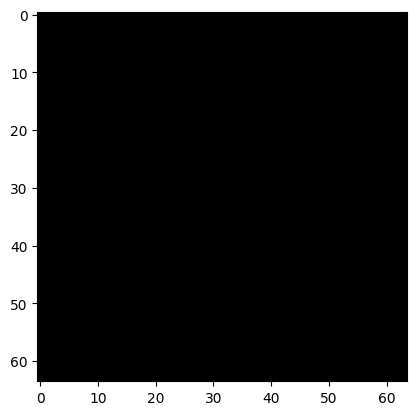

In [7]:
spatial_coord = (0,0,0)
sample_vol = ds_spatial[spatial_coord]['img']
print(ds_spatial[spatial_coord]['phi_gen'], ds_spatial[spatial_coord]['phi'])
plt.imshow(sample_vol[:,0,:], cmap='gray')

In [8]:
phi_list = []
phi_gen_list = []

for keys in ds_spatial.keys():
    phi_list.append(ds_spatial[keys]['phi'])
    img = ds_spatial[keys]['img']
    phi_gen = img_prc.phi(img)
    phi_gen_list.append(phi_gen)

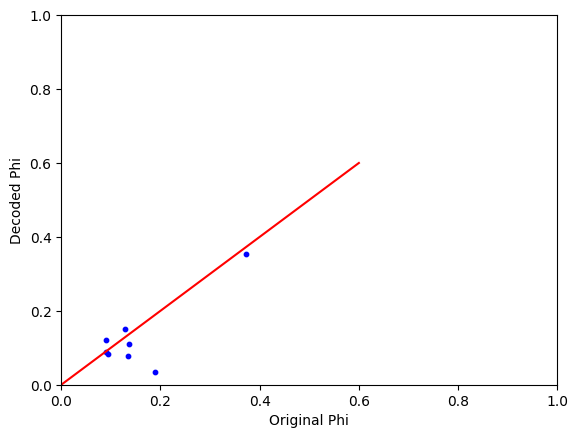

In [9]:

f = plt.figure()
plt.scatter(phi_list, phi_gen_list,s=10,c='b')
plt.plot([0,0.6],[0,0.6],c='r')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Original Phi')
plt.ylabel('Decoded Phi')
plt.show()

#### Experiment with single token generation

In [124]:
cond_list = []
token_list = []


# dummy generation
sos_token = 3000
top_k = 12
temperature = 1

phi = 0.2
cond_vec = torch.tensor([phi, 0, 0, 0]).to(device)
cond_vec = expand_cond_single(cond_vec)
cond_list.append(cond_vec)
# cond_vec = add_noise_to_cond(cond_vec,device)

sos_tokens = torch.ones(1, total_features) * sos_token
sos_tokens = sos_tokens.long().to(device)
token_list.append(sos_tokens)

token_nxt = model_transformer.model.sample(
    sos_tokens,
    cond_vec,
    temperature=temperature,
    top_k=top_k,
    features_num=total_features
    )

token_list.append(token_nxt)


# dummy - 2
# generate conditional informatino
cond_vec = torch.tensor([phi, 0, 0, 0]).to(device)
cond_vec = expand_cond_single(cond_vec)
# cond_vec = add_noise_to_cond(cond_vec,device)
cond_list.append(cond_vec)
cond_input = torch.cat(cond_list, dim=1)

# aggregate previous tokens
token_input = torch.cat(token_list, dim=1)
token_nxt = model_transformer.model.sample(token_input, cond_input,temperature=temperature,top_k=top_k,features_num=total_features)
token_list.append(token_nxt)





cond_vec = torch.tensor([phi, 0, 0, 0]).to(device)
cond_vec = expand_cond_single(cond_vec)
# cond_vec = add_noise_to_cond(cond_vec,device)
cond_list.append(cond_vec)
cond_input = torch.cat(cond_list, dim=1)

# aggregate previous tokens
token_input = torch.cat(token_list, dim=1)
token_nxt = model_transformer.model.sample(token_input, cond_input,temperature=temperature,top_k=top_k,features_num=total_features)


z_current = model_vqgan.tokens_to_z(token_nxt,total_features_vec_num=total_features)
img = gen_img_from_z(z_current)


0.22812652587890625


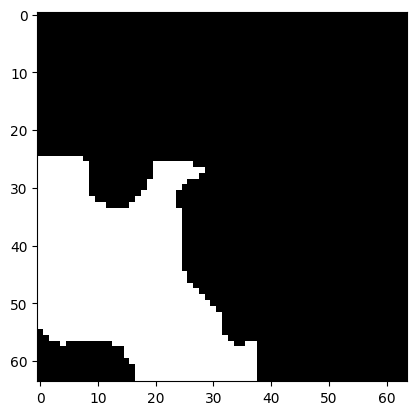

In [125]:
plt.imshow(img[0,:,:], cmap='gray')
print(img_prc.phi(img))


In [91]:
for key in ds_spatial.keys():
    print(key)

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)


#### validation

In [17]:
for i in range(2):
    for j in range(2):
        for k in range(2):
            img_sample = ds_spatial[(i,j,k)]['img']
            img_sample_test = volume[64*i:64*(i+1),64*j:64*(j+1),64*k:64*(k+1)]
            assert np.allclose(img_sample,img_sample_test)


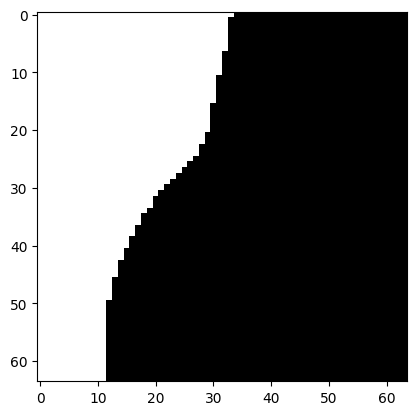

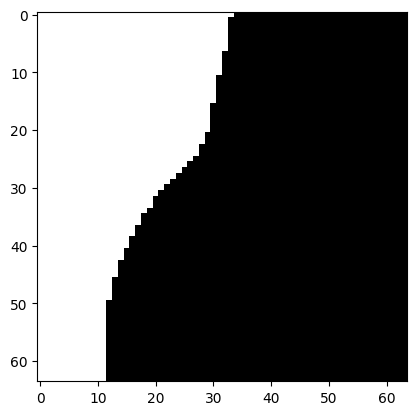

In [101]:
f = plt.figure()
plt.imshow(img_sample[0,:,:],cmap='gray')   
plt.show()

f = plt.figure()
plt.imshow(img_sample_test[0,:,:],cmap='gray')
plt.show()